In [38]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [39]:
try:
    # Disable all GPUS
    visible_devices = tf.config.get_visible_devices()
    print(visible_devices)
except:
    # Invalid device or cannot modify virtual devices once initialized.
    pass

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [40]:
BATCH_SIZE = 32
IMAGE_SIZE = 128
CHANNELS=3

In [41]:
train_path ='AlzheimerDataset/train'
test_path = 'AlzheimerDataset/test'

In [42]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.05,  # Specify the validation split ratio
    subset="training",
    labels="inferred",
    label_mode="categorical"  # Specify that this is the training set
)

validation_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_path,
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    validation_split=0.05,  # Specify the validation split ratio
    subset="validation",
    labels="inferred",
    label_mode="categorical"  # Specify that this is the validation set
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_path,
    seed=12,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    labels="inferred",
label_mode="categorical",

)

Name_of_the_classes = train_dataset.class_names

train_ds = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = validation_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

Found 5121 files belonging to 4 classes.
Using 4865 files for training.
Found 5121 files belonging to 4 classes.
Using 256 files for validation.
Found 1279 files belonging to 4 classes.


In [43]:
Name_of_the_classes = train_dataset.class_names
Name_of_the_classes

['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']

In [44]:
train_ds.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))

In [45]:
train_dataset.element_spec

(TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(None, 4), dtype=tf.float32, name=None))

In [46]:
resize_and_rescale = tf.keras.Sequential([
  layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.Rescaling(1./255)
])
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

In [47]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import math
import os


In [48]:
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix

import keras
from tensorflow import keras
from keras import Sequential
from keras import layers
import tensorflow as tf
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense, Dropout, Activation, BatchNormalization, Flatten, Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [49]:
from keras.applications import VGG16
from keras.models import Model
from keras.layers import Input, Flatten, Dense
from keras.optimizers import Adam
from keras.applications import EfficientNetB0,VGG19

In [50]:
dropout_rate = 0.2
activation = "relu"
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
base_model = VGG19(include_top=False, weights='imagenet', input_shape=(128, 128, 3))
base_model.trainable = False

In [51]:
model = tf.keras.models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.Flatten(),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(64, activation=activation),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(256, activation=activation),
            tf.keras.layers.Dropout(dropout_rate),
            tf.keras.layers.BatchNormalization(),
            tf.keras.layers.Dense(128, activation=activation),
            tf.keras.layers.Dropout(dropout_rate),
          
    tf.keras.layers.Dense(4, activation='softmax')
])

In [52]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.AUC(name='auc')])

In [53]:
def checkpoint_callback():
    
    checkpoint_filepath = 'checkpoint'
    
    model_checkpoint_callback= ModelCheckpoint(filepath=checkpoint_filepath,
                           save_weights_only=False,
                           frequency='epoch',
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    
    return model_checkpoint_callback

    

def early_stopping(patience):
    es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, verbose=1)
    return es_callback


In [54]:
EPOCHS = 10
checkpoint_callback = checkpoint_callback()
early_stopping = early_stopping(patience=5)
callbacks = [checkpoint_callback, early_stopping]

In [55]:
history = model.fit(train_ds, epochs = EPOCHS, validation_data = val_ds, callbacks = callbacks)

Epoch 1/10


C:\Users\chinm\AppData\Roaming\Python\Python38\site-packages\keras\src\backend.py:5562: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


153/153 [==============================] - 548s 3s/step - loss: 1.2186 - auc: 0.7540 - val_loss: 1.1189 - val_auc: 0.7876
Epoch 2/10
153/153 [==============================] - 505s 3s/step - loss: 1.0598 - auc: 0.7937 - val_loss: 1.0460 - val_auc: 0.7926
Epoch 3/10
153/153 [==============================] - 516s 3s/step - loss: 1.0405 - auc: 0.7935 - val_loss: 1.0065 - val_auc: 0.8092
Epoch 4/10
153/153 [==============================] - 543s 4s/step - loss: 1.0109 - auc: 0.8030 - val_loss: 0.9945 - val_auc: 0.8030
Epoch 5/10
153/153 [==============================] - 590s 4s/step - loss: 0.9937 - auc: 0.8079 - val_loss: 0.9647 - val_auc: 0.8133
Epoch 6/10
153/153 [==============================] - 589s 4s/step - loss: 0.9708 - auc: 0.8143 - val_loss: 0.9701 - val_auc: 0.8244
Epoch 7/10
153/153 [==============================] - 574s 4s/step - loss: 0.9644 - auc: 0.8204 - val_loss: 0.9629 - val_auc: 0.8268
Epoch 8/10
153/153 [==============================] - 511s 3s/step - loss: 0.954

In [56]:
scores = model.evaluate(test_ds)

40/40 [==============================] - 101s 2s/step - loss: 0.9967 - auc: 0.8286


In [57]:
acc = history.history['auc']
val_acc = history.history['val_auc']

loss = history.history['loss']
val_loss = history.history['val_loss']

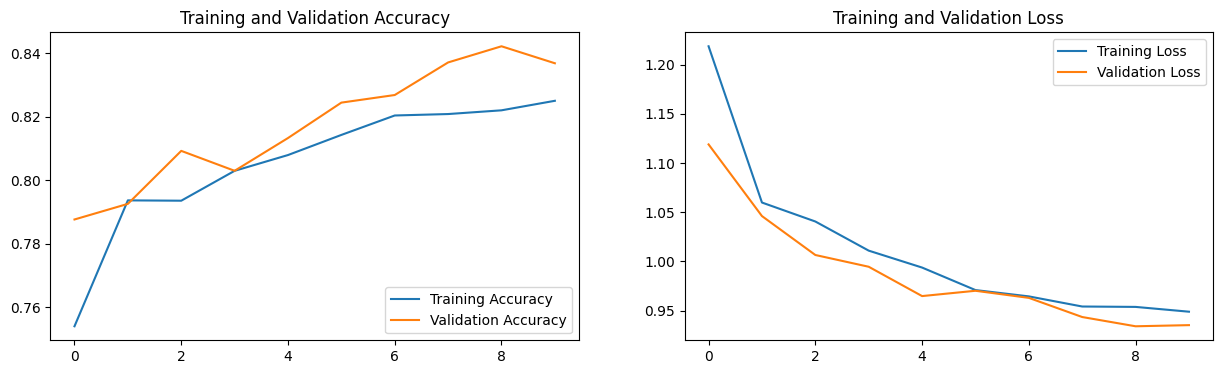

In [58]:
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label='Training Loss')
plt.plot(range(EPOCHS), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

first image to predict
actual label: NonDemented
1/1 [==============================] - 2s 2s/step
predicted label: NonDemented


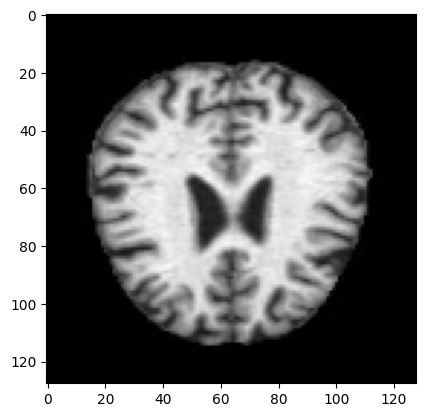

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",Name_of_the_classes[np.argmax(first_label)])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",Name_of_the_classes[np.argmax(batch_prediction[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = Name_of_the_classes[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 101ms/step


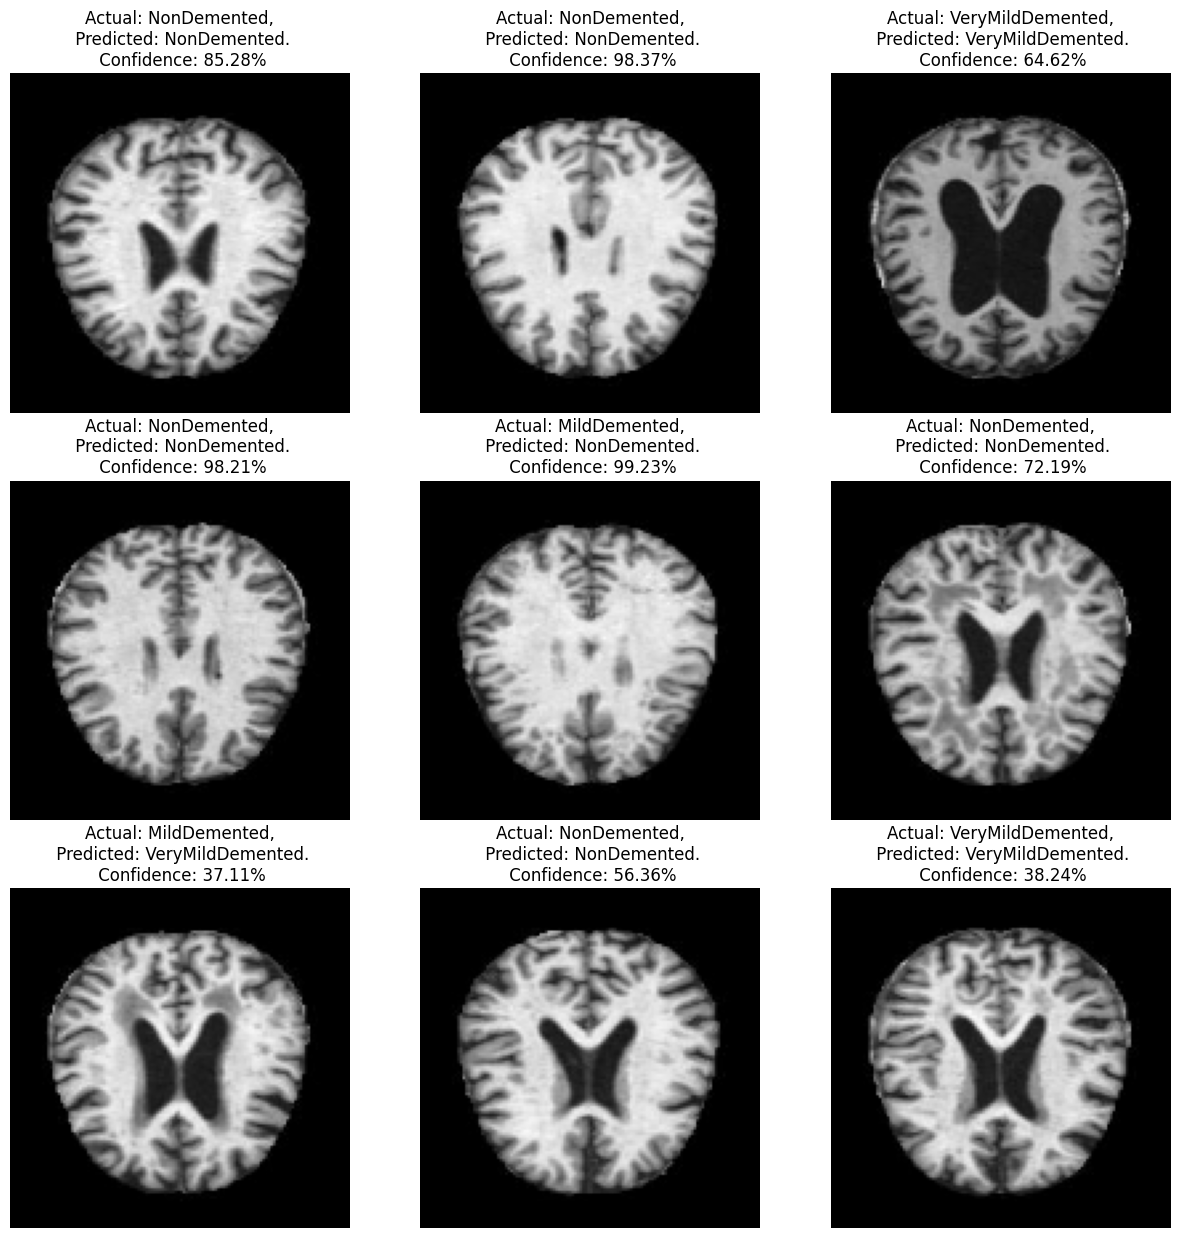

In [61]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = Name_of_the_classes[np.argmax(labels[i])] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

In [62]:
import os

model.save("models1.h5") 

In [63]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_5 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 sequential_6 (Sequential)   (None, 128, 128, 3)       0         
                                                                 
 vgg19 (Functional)          (None, 4, 4, 512)         20024384  
                                                                 
 global_average_pooling2d_2  (None, 512)               0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_12 (Dropout)        (None, 512)               0         
                                                                 
 flatten_3 (Flatten)         (None, 512)               0         
                                                      

In [32]:
!pip install visualkeras

Defaulting to user installation because normal site-packages is not writeable
   ---------------------------------------- 0.0/43.2 kB ? eta -:--:--
   ------------------------------------- -- 41.0/43.2 kB 1.9 MB/s eta 0:00:01
   ------------------------------------- -- 41.0/43.2 kB 1.9 MB/s eta 0:00:01
   ---------------------------------------- 43.2/43.2 kB 211.6 kB/s eta 0:00:00


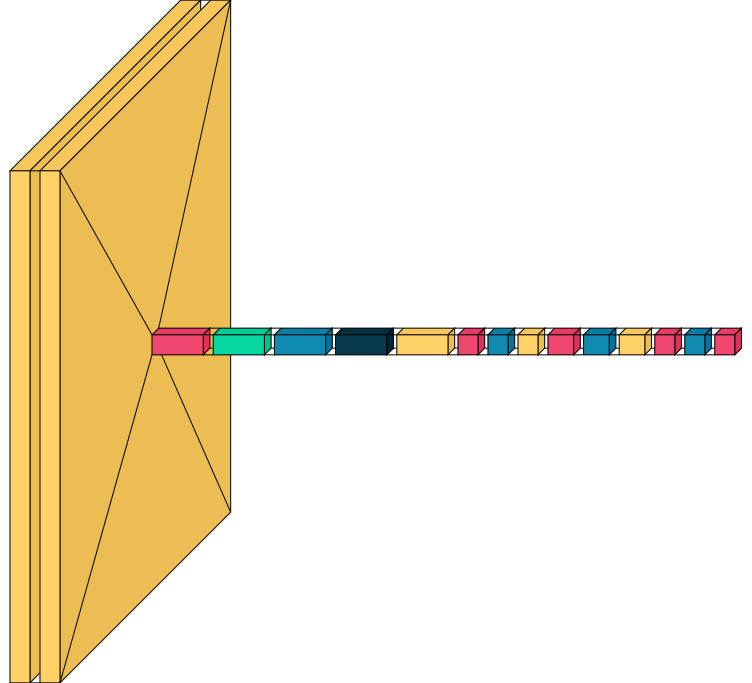

In [64]:
import visualkeras
visualkeras.layered_view(model).show() # display using your system viewer
visualkeras.layered_view(model, to_file='output.png') # write to disk
visualkeras.layered_view(model, to_file='output.png').show() # write and show

visualkeras.layered_view(model)